Titanic project

3 fichiers csv : <li> gender_submission (exemple de BDD à soumettre) </li>
                 <li> - test (fichier d'entraînement/ BDD raw) </li>
                 <li> - train (aussi connu as "ground truth" fichier de vérification pour l'entraînement) </li>

Il va falloir d'abord analyser les données du fichier train.csv pour déterminer quels sont les facteurs importants de survie
                

1/ Analyse de données train.csv

In [72]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt

# On import la data

test = pd.read_csv("../titanic-project/titanic_data/test.csv")
train = pd.read_csv("../titanic-project/titanic_data/train.csv")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


On compare les différences de survivabilité entre les hommes et les femmes :

Males total: 577
Females total: 314
Males Survivants: 109
Females Survivants: 233
{'Survivants': [109, 233], 'Mort': [468, 81]}


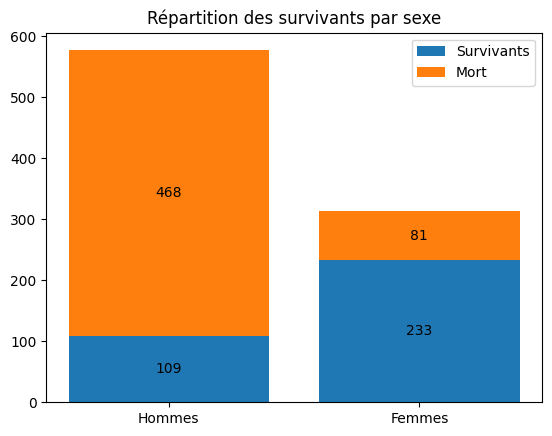

In [ ]:
# Graph Male/Female

#make data
males_total = len(train.loc[(train['Sex'] == 'male')])
females_total = len(train.loc[(train['Sex'] == 'female')])
print(f"Males total: {males_total}\nFemales total: {females_total}")
males_total_survived = len(train.loc[(train['Sex'] == 'male') & (train['Survived'] == 1)])
females_total_survived = len(train.loc[(train['Sex'] == 'female') & (train['Survived'] == 1)])
print(f"Males Survivants: {males_total_survived}\nFemales Survivants: {females_total_survived}")

count = {
    "Survivants": [males_total_survived, females_total_survived],
    "Mort": [males_total-males_total_survived, females_total-females_total_survived]
}
print(count)

fig, ax = plt.subplots()
x = np.zeros(2) # list = [0,0 hommes ; 0,0 femmes]
ax.set_title("Répartition des survivants par sexe")
for key, count in count.items():
    i = ax.bar(('Hommes', 'Femmes'),count, width=0.8, bottom=x, label=key)
    x+=count
    ax.legend()
    ax.bar_label(i, label_type="center")

plt.show()

On compare les différences de survivabilité selon la classe :

Class 1: 216
Class 2: 184
Class 3: 491
Class 1: 136
Class 2: 87
Class 3: 119
{'Survivants': [136, 87, 119], 'Mort': [80, 97, 372]}


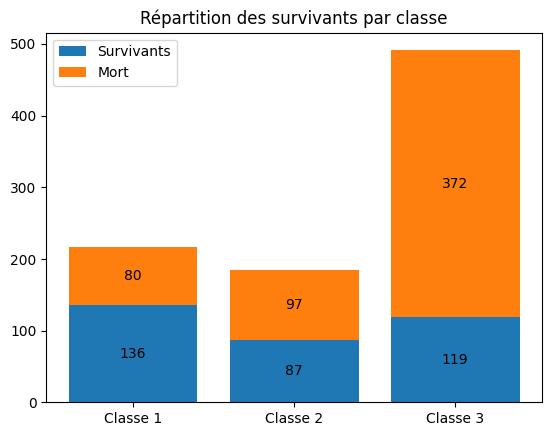

In [117]:
# Graph Classe

#make data
class1_total = len(train.loc[train['Pclass'] == 1])
class2_total = len(train.loc[train['Pclass'] == 2])
class3_total = len(train.loc[train['Pclass'] == 3])
print(f"Class 1: {class1_total}\nClass 2: {class2_total}\nClass 3: {class3_total}")
class1_total_survived = len(train.loc[(train['Pclass'] == 1) & (train['Survived'] == 1)])
class2_total_survived = len(train.loc[(train['Pclass'] == 2) & (train['Survived'] == 1)])
class3_total_survived = len(train.loc[(train['Pclass'] == 3) & (train['Survived'] == 1)])
print(f"Class 1: {class1_total_survived}\nClass 2: {class2_total_survived}\nClass 3: {class3_total_survived}")
count = {
    "Survivants": [class1_total_survived, class2_total_survived, class3_total_survived],
    "Mort": [class1_total-class1_total_survived, class2_total-class2_total_survived, class3_total-class3_total_survived]
}
print(count)

fig, ax = plt.subplots()
x = np.zeros(3) # list = [0,0 hommes ; 0,0 femmes]
ax.set_title("Répartition des survivants par classe")
for key, count in count.items():
    i = ax.bar(('Classe 1', 'Classe 2', 'Classe 3'),count, width=0.8, bottom=x, label=key)
    x+=count
    ax.legend()
    ax.bar_label(i, label_type="center")

plt.show()

On compare la différence de survivabilité par Age:

[22.0, 38.0, 26.0, 35.0, 35.0, nan, 54.0, 2.0, 27.0, 14.0, 4.0, 58.0, 20.0, 39.0, 14.0, 55.0, 2.0, nan, 31.0, nan, 35.0, 34.0, 15.0, 28.0, 8.0, 38.0, nan, 19.0, nan, nan, 40.0, nan, nan, 66.0, 28.0, 42.0, nan, 21.0, 18.0, 14.0, 40.0, 27.0, nan, 3.0, 19.0, nan, nan, nan, nan, 18.0, 7.0, 21.0, 49.0, 29.0, 65.0, nan, 21.0, 28.5, 5.0, 11.0, 22.0, 38.0, 45.0, 4.0, nan, nan, 29.0, 19.0, 17.0, 26.0, 32.0, 16.0, 21.0, 26.0, 32.0, 25.0, nan, nan, 0.83, 30.0, 22.0, 29.0, nan, 28.0, 17.0, 33.0, 16.0, nan, 23.0, 24.0, 29.0, 20.0, 46.0, 26.0, 59.0, nan, 71.0, 23.0, 34.0, 34.0, 28.0, nan, 21.0, 33.0, 37.0, 28.0, 21.0, nan, 38.0, nan, 47.0, 14.5, 22.0, 20.0, 17.0, 21.0, 70.5, 29.0, 24.0, 2.0, 21.0, nan, 32.5, 32.5, 54.0, 12.0, nan, 24.0, nan, 45.0, 33.0, 20.0, 47.0, 29.0, 25.0, 23.0, 19.0, 37.0, 16.0, 24.0, nan, 22.0, 24.0, 19.0, 18.0, 19.0, 27.0, 9.0, 36.5, 42.0, 51.0, 22.0, 55.5, 40.5, nan, 51.0, 16.0, 30.0, nan, nan, 44.0, 40.0, 26.0, 17.0, 1.0, 9.0, nan, 45.0, nan, 28.0, 61.0, 4.0, 1.0, 21.0, 56.

Text(0.5, 1.0, 'Répartition des survivants par Age')

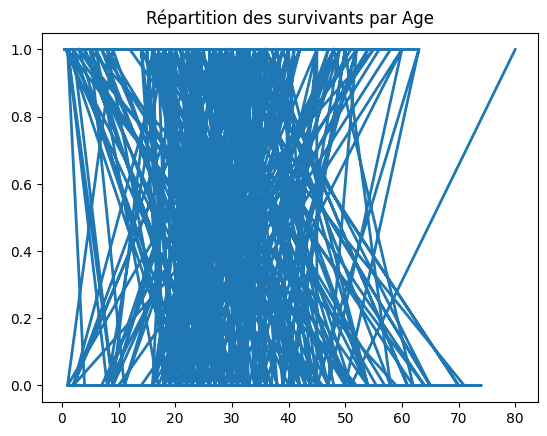

In [ ]:
# Graph Age

# make data
# on remplace les missing values par la médian des ages du même sexe
median_homme = train['']
# x = train['Age'].to_list()
# print(x)
# y = train['Survived'].to_list()
# print(y)

# fig, ax = plt.subplots()
# ax.plot(x, y, linewidth=2.0)
# ax.set_title('Répartition des survivants par Age')

2/ Manipulation de données test.csv

On regarde le type de données de chaque colonne

In [25]:
print(train.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


On regarde que la table s'organise en 12 colonnes : <ul>ID, passengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin et Embarked</ul>
<ul>Variable / Definition / Key / Contraintes</ul>
<ul>PassengerID / ID table / Num(Int) / Unique</ul>
<ul>pclass /	Ticket class / Num(Int) 1,2 ou 3</ul>
<ul>sex /	Sex / Alpha 2 choices : male & female	</ul>
<ul>Age /	Age in years / Num(Decimal(10,1)) avec 0.5 de step</ul>
<ul>sibsp  /	# of siblings & spouses aboard the Titanic / Num(Int)</ul>
<ul>parch /	# of parents & children aboard the Titanic / Num(Int)</ul>
<ul>ticket	/ Ticket number / Alpha / Unique</ul>
<ul>fare /	Passenger fare / Num(Float)</ul>
<ul>cabin /	Cabin number / Alpha</ul>
<ul>embarked / Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton / Alpha 3 choices : C,Q,S</ul>

On vérifie maintenant que toutes les données dans chaque colonne correspond bien à leur Key définit plus haut précédemment

In [ ]:
# On doit vérifier quelles colonnes contiennent des missing datas et quelles colonnes n'en contiennent pas
print(test.isna().sum())
print("----------------------------")

# On teste les valeurs dans Sexe pour voir si elles correspondent bien à la Key
# Contraintes : string contenant 'male' ou 'female'
test2 = test['Sex'].isin(['male','female']) 
if test2.all() == True:
    print('données vérifiées sexe')
else:
    print('non vérifiées sexe')
    print(test2.value_counts())

# On teste les valeurs dans Pclass pour voir si elles correspondent bien à la Key
# Contraintes : Int égal à 1, 2 ou 3
test2 = test['Pclass'].isin([1,2,3])
if test2.all() == True:
    print('données vérifiées pclass')
else:
    print('non vérifiées pclass')
    print(test2.value_counts())

# On teste les valeurs dans SibSp pour voir si elles correspondent bien à la Key
# Contraintes : Supérieure ou égale à 0, tous des entiers et non irréaliste
test2 = test['SibSp'] >= 0
if (test2.all() == True) and (test2.max() < 10):
    print('données vérifiées sibSp')
else:
    print('non vérifiées sibsp')
    print(test2.value_counts())
    
# On teste les valeurs dans Parch pour voir si elles correspondent bien à la Key
# Contraintes : Supérieure ou égale à 0, tous des entiers et non irréaliste
test2 = test['Parch'] >= 0
if (test2.all() == True) and (test2.max() < 10):
    print('données vérifiées Parch')
else:
    print('non vérifiées Parch')
    print(test2[~(test2.all() == True) and (test2.max() < 10)])

# On teste les valeurs dans Age pour voir si elles correspondent bien à la Key
# On doit drop les missing values ou sinon cela fausse le résultat de l'analyse
# Contraintes : Strictement supérieur 0, des float avec un step de 0.5, non irréaliste
test2 = test['Age'].dropna()
test2_Na = test2.isin(np.arange(0,120,0.5))
if (test2_Na.all() == True):
    print('données vérifiées Age')
else:
    print('non vérifiées Age')
    print(test2[~test2_Na])


# On teste les valeurs dans Ticket pour voir si elles correspondent bien à la Key
# Contraintes : Alpha-num strings uniques
test_t = test['Ticket']
test2 = test_t.isin([test_t.value_counts])
if (test2.all() == True):
    print('données vérifiées ticket')
else:
    print('non vérifiées ticket')
    print(~test2)
# if (test2.all() == True) and (test2.max() < 10):
#     print('données vérifiées sibSp')
# else:
#     print('non vérifiées sibsp')
#     print(test2.value_counts())





PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------------------------
données vérifiées sexe
données vérifiées pclass
données vérifiées sibSp
données vérifiées Parch
non vérifiées Age
201    0.33
250    0.92
281    0.75
307    0.83
354    0.17
Name: Age, dtype: float64
non vérifiées ticket
0      True
1      True
2      True
3      True
4      True
       ... 
413    True
414    True
415    True
416    True
417    True
Name: Ticket, Length: 418, dtype: bool


Age et Cabin ont des données manquantes. Ce sont tout les deux des types object, on fait donc un fillna("unknown")

In [6]:
test.fillna("unknown")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,unknown,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0,unknown,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,unknown,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,unknown,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,unknown,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,unknown,0,0,A.5. 3236,8.05,unknown,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.25,unknown,S
416,1308,3,"Ware, Mr. Frederick",male,unknown,0,0,359309,8.05,unknown,S
